#Imports and Installs

In [0]:
!pip install scikit-multilearn
!pip install -U yellowbrick
!pip install imbalanced-learn
!pip install skrebate -U

  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
  Created wheel for skrebate: filename=skrebate-0.6-cp37-none-any.whl size=29334 sha256=727b47ed3c0ec00de506e2f387a9f3cd4d8b44cb34e1e4fdebd6ec0cfc5e34f2
  Stored in directory: C:\Users\haltn\AppData\Local\pip\Cache\wheels\f5\99\36\c827bcfa6852c6d068895b2723c57cea84f93642270c6dc05c
Successfully built skrebate


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os
import xml.etree.ElementTree as et

#NLTK
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer #

#sklearn
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score , multilabel_confusion_matrix, hamming_loss
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics  
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer #
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, MiniBatchKMeans #

#scipy
from scipy.stats import uniform, randint as sp_randint

#skmultilearn
from skmultilearn.problem_transform import LabelPowerset #

#seaborn
import seaborn as sns

#yellowbrick
from yellowbrick.text import TSNEVisualizer, FreqDistVisualizer, PosTagVisualizer #
from yellowbrick.cluster import KElbowVisualizer #

#imblearn
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN #
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks, InstanceHardnessThreshold, RandomUnderSampler

import warnings


warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

C:\Users\haltn\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\haltn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\haltn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\haltn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\haltn\AppData\Roaming\nltk_data...

True

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

# Global Variables

In [0]:
#STEP 1
STOP_WORDS = set(stopwords.words('english')) 
REMOVE_EMPTY_ROWS = True

#STEP 2
CLUSTER_COUNT = 0
MLP_TRAIN_RATIO = 0.8


# Functions

In [0]:
def prepare_text(text):
  
    #convert to lower case
    text = text.lower()

    #tockenize the words
    text = nltk.word_tokenize(text)

    #remove unwanted characters
    text = [re.sub('[^a-zA-Z]', '', str(w)) for w in text]
        
    #remove empty fields
    text = list( filter(None, text) )
        
    #remove stop words
    filtered_text = [w for w in text if not w in STOP_WORDS]
        
    #remove single characters
    filtered_text_no_chars = [w for w in filtered_text if len(w) > 2]
    
    return filtered_text_no_chars

In [0]:
#Convert nltk pos to wordnet pos
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J') or treebank_tag == 'PDT':
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R') or treebank_tag == 'EX' or treebank_tag == 'IN':
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [0]:
#select the optimal number of clusters by fitting the model with a range of values for K.
def ClusterCalcultor(X_tfidf_resampled, visual=False):
  
  model = MiniBatchKMeans(random_state=42, init_size=1000, batch_size=1000) #KMeans()
  
  visualizer = KElbowVisualizer(model, k=(4,12), metric='silhouette', timings=True, locate_elbow=True)
  visualizer.fit(X_tfidf_resampled.todense())        # Fit the data to the visualizer
  
  if(visual==True):
    visualizer.show() 

  return visualizer.elbow_value_

#reference:https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

In [0]:
#Cluster evaluation

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_cluster_quality(df, clusters):
  print('silhouette_score:', silhouette_score(df, clusters.labels_, metric='euclidean')) 
  print('calinski_harabasz_score:', calinski_harabasz_score(df.todense(), clusters.labels_)) 
  print('davies_bouldin_score:', davies_bouldin_score(df.todense(), clusters.labels_)) 

###Visualization Functions

In [0]:
#PosTag Visualization
def PosTagVisualization(tokenizer_pos):
  viz = PosTagVisualizer()
  tagged_stanzas = [tokenizer_pos]
  viz.fit(tagged_stanzas)
  viz.show()

In [0]:
#Term Frequency Visualization
def TermFrequencyVisualization(bow, tfidfvector, number_of_words):
  features = bow.get_feature_names()

  visualizer = FreqDistVisualizer(features=features, orient='v', n = number_of_words)
  visualizer.fit(tfidfvector)
  visualizer.show()

In [0]:
#Class distribution graph before/after resampling
def ClassDistributionPlot(label_df_Y, df_Y_label_resampled):
  
  fig = plt.figure(figsize=(20,20))
  (ax_test, ax_train) = fig.subplots(ncols=2, nrows=1)

  g1 = sns.barplot(x=label_df_Y.sum(axis=0), y=label_df_Y.columns.values, ax=ax_test)
  g1.set_title("class distribution before resampling")
  
  g2 = sns.barplot(x=df_Y_label_resampled.sum(axis=0), y=label_df_Y.columns.values, ax=ax_train)
  g2.set_title("class distribution in training set after resampling")

In [0]:
#Visualizing document similarity using t-distributed stochastic neighbor embedding, t-SNE.
def TsneVisualization(X_tfidf_resampled):
  tsne = TSNEVisualizer()
  tsne.fit(X_tfidf_resampled)
  tsne.show()

In [0]:
#Visualize quality of the cluster
def ClusterTsneVisualization(X_tfidf_resampled, clustering):
  tsne = TSNEVisualizer()
  tsne.fit(X_tfidf_resampled, ["c{}".format(c) for c in clustering.labels_])
  tsne.show()

#reference:https://www.scikit-yb.org/en/latest/api/text/tsne.html

#Step 1: Load Data & Prepare Environment

In [0]:
#Read CSV file containing Reuters data
#data_path = "drive/My Drive/Extracted_Reuters_Data/project_reuters_df.csv"
data_path = "project_reuters_df.csv"
df_main = pd.read_csv(data_path, index_col=[0])

#Convert Strings of lists into lists of strings
import ast
df_main['bip_topics'] = df_main['bip_topics'].apply(lambda s: s.replace(' ',','))         #replace string with comma as this column is string originally
df_main['bip_topics'] = df_main['bip_topics'].apply(lambda s: ast.literal_eval(s))        #convert string which is in list format to a real list

#Drop empty topics
if(REMOVE_EMPTY_ROWS):  
  index = df_main[ df_main['bip_topics'].apply(lambda x: True if len(x) == 0 else False) ].index 
  df_main.drop(index, inplace=True) 

In [0]:
df_main

,item_id,xml_filename,headline,text,bip_topics,date_published
0,429411,429411newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ L 66 OF MARCH 6...,* Council Regulation (EC) No 390/97 of 20 Dec...,"[G15, GCAT]",1997-03-10
1,429412,429412newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ C 74 OF MARCH 8...,* (Note - contents are displayed in reverse o...,"[G15, GCAT]",1997-03-10
2,429413,429413newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ C 73 OF MARCH 8...,* (Note - contents are displayed in reverse o...,"[G15, GCAT]",1997-03-10
3,429414,429414newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ L 68 OF MARCH 8...,* (Note - contents are displayed in reverse o...,"[G15, GCAT]",1997-03-10
4,429415,429415newsML.xml,Canada provincial T-bill auction results - Man...,DATE PROV MAT C$AMT AVG CHG PRICE ...,"[M13, M131, MCAT]",1997-03-10
...,...,...,...,...,...,...
48368,477879,477879newsML.xml,World Bank says Bangladesh must open up economy.,The World Bank has asked Bangladesh to reduce...,"[E11, E12, E51, ECAT]",1997-03-31
48371,477882,477882newsML.xml,Indian shares plunge 8.6 pct on political crisis.,Indian shares plunged more than eight percent...,[M11],1997-03-31
48372,477883,477883newsML.xml,"Singapore shares open weak, funds stay sidelined.",Singapore shares opened weaker on Monday with...,[M11],1997-03-31
48373,477884,477884newsML.xml,Selecta declares two centavo cash dividend.,Selecta Dairy Products Inc declared on Monday...,[C151],1997-03-31


In [0]:
# all the possible values for bip:topics. Consider that each news can belong to more than one topic
mlb = MultiLabelBinarizer()

df_bip_topics_target = pd.DataFrame(df_main['bip_topics'])
df_bip_topics_target = df_bip_topics_target.join(pd.DataFrame(mlb.fit_transform(df_bip_topics_target.pop('bip_topics')),
                                                              columns=mlb.classes_,
                                                              index=df_bip_topics_target.index))

print(df_bip_topics_target)

#reference:https://www.kaggle.com/roccoli/multi-label-classification-with-sklearn

       C11  C12  C13  C14  C15  C151  C1511  C152  C16  C17  ...  M11  M12  \
0        0    0    0    0    0     0      0     0    0    0  ...    0    0   
1        0    0    0    0    0     0      0     0    0    0  ...    0    0   
2        0    0    0    0    0     0      0     0    0    0  ...    0    0   
3        0    0    0    0    0     0      0     0    0    0  ...    0    0   
4        0    0    0    0    0     0      0     0    0    0  ...    0    0   
...    ...  ...  ...  ...  ...   ...    ...   ...  ...  ...  ...  ...  ...   
48368    0    0    0    0    0     0      0     0    0    0  ...    0    0   
48371    0    0    0    0    0     0      0     0    0    0  ...    1    0   
48372    0    0    0    0    0     0      0     0    0    0  ...    1    0   
48373    0    0    0    0    0     1      0     0    0    0  ...    0    0   
48374    0    0    0    0    0     0      0     0    0    0  ...    1    0   

       M13  M131  M132  M14  M141  M142  M143  MCAT  
0        

Cleaning the Data

In [0]:
df_main['text'] = df_main['text'].apply(lambda s: prepare_text(s))

In [0]:
df_main

,item_id,xml_filename,headline,text,bip_topics,date_published
0,429411,429411newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ L 66 OF MARCH 6...,"[council, regulation, december, fixing, certai...","[G15, GCAT]",1997-03-10
1,429412,429412newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ C 74 OF MARCH 8...,"[note, contents, displayed, reverse, order, pr...","[G15, GCAT]",1997-03-10
2,429413,429413newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ C 73 OF MARCH 8...,"[note, contents, displayed, reverse, order, pr...","[G15, GCAT]",1997-03-10
3,429414,429414newsML.xml,OFFICIAL JOURNAL CONTENTS - OJ L 68 OF MARCH 8...,"[note, contents, displayed, reverse, order, pr...","[G15, GCAT]",1997-03-10
4,429415,429415newsML.xml,Canada provincial T-bill auction results - Man...,"[date, prov, mat, amt, avg, chg, price, man, m...","[M13, M131, MCAT]",1997-03-10
...,...,...,...,...,...,...
48368,477879,477879newsML.xml,World Bank says Bangladesh must open up economy.,"[world, bank, asked, bangladesh, reduce, impor...","[E11, E12, E51, ECAT]",1997-03-31
48371,477882,477882newsML.xml,Indian shares plunge 8.6 pct on political crisis.,"[indian, shares, plunged, eight, percent, pani...",[M11],1997-03-31
48372,477883,477883newsML.xml,"Singapore shares open weak, funds stay sidelined.","[singapore, shares, opened, weaker, monday, fu...",[M11],1997-03-31
48373,477884,477884newsML.xml,Selecta declares two centavo cash dividend.,"[selecta, dairy, products, inc, declared, mond...",[C151],1997-03-31


**Pos Tagging**

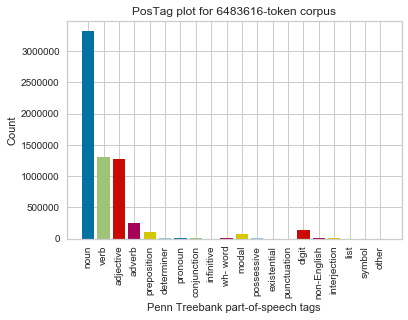

[[('council', 'NN'), ('regulation', 'NN'), ('december', 'VB'), ('fixing', 'VBG'), ('certain', 'JJ'), ('fish', 'JJ'), ('stocks', 'NNS'), ('groups', 'NNS'), ('fish', 'JJ'), ('stocks', 'NNS'), ('total', 'JJ'), ('allowable', 'JJ'), ('catches', 'NNS'), ('certain', 'JJ'), ('conditions', 'NNS'), ('may', 'MD'), ('fished', 'VB'), ('council', 'NN'), ('regulation', 'NN'), ('december', 'VB'), ('laying', 'VBG'), ('certain', 'JJ'), ('measures', 'NNS'), ('conservation', 'VBP'), ('management', 'NN'), ('fishery', 'NN'), ('resources', 'NNS'), ('applicable', 'JJ'), ('vessels', 'NNS'), ('flying', 'VBG'), ('flag', 'NN'), ('norway', 'RB'), ('council', 'NN'), ('regulation', 'NN'), ('december', 'VB'), ('allocating', 'VBG'), ('certain', 'JJ'), ('catch', 'NN'), ('quotas', 'NNS'), ('member', 'NN'), ('states', 'NNS'), ('vessels', 'NNS'), ('fishing', 'VBG'), ('norwegian', 'JJ'), ('exclusive', 'JJ'), ('economic', 'JJ'), ('zone', 'NN'), ('fishing', 'VBG'), ('zone', 'NN'), ('around', 'RB'), ('jan', 'VBZ'), ('mayen', 

In [0]:
tokenizer_pos = []
clean_text = df_main['text']

for w in clean_text:
    pos_tag = nltk.pos_tag(w)
    tokenizer_pos.append(pos_tag)

PosTagVisualization(tokenizer_pos)

print(tokenizer_pos[:5])

**Lemmatization**

In [0]:
lem = WordNetLemmatizer()
lemmatize_w = []
lemmatize_list = []

#Lemmatize
for w in tokenizer_pos:
  dummy_lemma = []

  for lemma_list in w:
    x = lem.lemmatize(lemma_list[0], get_wordnet_pos((lemma_list[1])))
    dummy_lemma.append(x)
  
  lemmatize_w.append(dummy_lemma)

print(lemmatize_w[:5])

#Convert list of strings into full string.
for z in lemmatize_w:
    lemmatize_list.append(" ".join(z))

print(lemmatize_list[:5])

#Limit range for testing
#LIMIT = 48257
#lemmatize_list = lemmatize_list[0:LIMIT]
print(len(lemmatize_list))


#reference: https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
#reference: https://stackoverflow.com/questions/5364493/lemmatizing-pos-tagged-words-with-nltk

[['council', 'regulation', 'december', 'fix', 'certain', 'fish', 'stock', 'group', 'fish', 'stock', 'total', 'allowable', 'catch', 'certain', 'condition', 'may', 'fish', 'council', 'regulation', 'december', 'lay', 'certain', 'measure', 'conservation', 'management', 'fishery', 'resource', 'applicable', 'vessel', 'fly', 'flag', 'norway', 'council', 'regulation', 'december', 'allocate', 'certain', 'catch', 'quota', 'member', 'state', 'vessel', 'fish', 'norwegian', 'exclusive', 'economic', 'zone', 'fish', 'zone', 'around', 'jan', 'mayen', 'council', 'regulation', 'december', 'lay', 'certain', 'measure', 'conservation', 'management', 'fishery', 'resource', 'applicable', 'vessel', 'fly', 'flag', 'faroe', 'island', 'council', 'regulation', 'december', 'allocate', 'certain', 'catch', 'quota', 'member', 'state', 'vessel', 'fish', 'faroese', 'water', 'council', 'regulation', 'december', 'allocate', 'community', 'catch', 'quota', 'greenland', 'water', 'council', 'regulation', 'december', 'allocat

**Feature extraction**

Generate bag of words

In [0]:
# bag of words
count_vect = CountVectorizer(max_features = 7000)
count_vector = count_vect.fit_transform(lemmatize_list)

print(f"Number of words in Bag-Of-Words: {len(count_vect.get_feature_names())}")

Number of words in Bag-Of-Words: 7000


Generate TF-IDF weighted vector

In [0]:
# TF-IDF weighted vector
tfidf_transformer = TfidfTransformer()
tfidfvector = tfidf_transformer.fit_transform(count_vector)
print(f"TFIDF size: Rows={tfidfvector.shape[0]}, Columns={tfidfvector.shape[1]}")

print("\n", count_vect.get_feature_names()) 

TFIDF size: Rows=48257, Columns=7000

 ['aaa', 'aamodt', 'abacha', 'abandon', 'abare', 'abb', 'abbey', 'abc', 'abdul', 'abdullah', 'aberdeen', 'abide', 'abidjan', 'ability', 'able', 'abn', 'abnormal', 'aboard', 'abolish', 'aboriginal', 'abortion', 'abroad', 'absence', 'absent', 'absolute', 'absolutely', 'absorb', 'abu', 'abuse', 'academic', 'academy', 'accelerate', 'accept', 'acceptable', 'acceptance', 'accepted', 'access', 'accession', 'accident', 'accompany', 'accord', 'accordance', 'accordingly', 'account', 'accountant', 'accounting', 'accrue', 'accumulate', 'accuracy', 'accurate', 'accusation', 'accuse', 'ace', 'achieve', 'achievement', 'acid', 'acknowledge', 'acpc', 'acquire', 'acquisition', 'acre', 'acreage', 'across', 'act', 'action', 'active', 'actively', 'activist', 'activity', 'actor', 'actress', 'actual', 'actually', 'acute', 'ad', 'adam', 'adapt', 'add', 'added', 'addendum', 'addictive', 'addition', 'additional', 'address', 'adelaide', 'adequacy', 'adequate', 'adfl', 'adjac

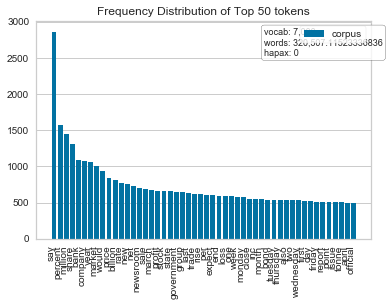

In [0]:
TermFrequencyVisualization(count_vect, tfidfvector, 50)

Handel imbalanced dataset using sampling techniques



In [0]:
#label_df_Y = df_bip_topics_target.iloc[0:LIMIT].copy()
label_df_Y = df_bip_topics_target.copy()

#drop ylabels with less than 1% representation in the feature set (decrease if required later)
drop_limit = 500
label_df_Y.drop([col for col, val in label_df_Y.sum().iteritems() if val < drop_limit], axis=1, inplace=True)

#converts multilabel into label encoding
lp = LabelPowerset()
yt = lp.transform(label_df_Y)

#Oversample data that is not majority to increase weight.
ros = RandomOverSampler(random_state=42,sampling_strategy='minority')
X_tfidf_oversampled, Y_label_oversampled = ros.fit_sample(tfidfvector, yt)


In [0]:
#Undersamples majority data to decrease weight.
tl  = TomekLinks(sampling_strategy='majority')
X_tfidf_resampled, Y_label_resampled = tl.fit_resample(X_tfidf_oversampled, Y_label_oversampled)

#Inverts the Multi-Label transformation to recreate the ML set
Y_label_resampled = lp.inverse_transform(Y_label_resampled)

# convert to dataframe format with labels (y_label_resampled is in a strange format, covert back too df)
df_Y_label_resampled = pd.DataFrame(Y_label_resampled.toarray(), columns=label_df_Y.columns.values)
df_X_tfidf_resampled = pd.DataFrame(X_tfidf_resampled.toarray(), columns=count_vect.get_feature_names())


#reference: https://github.com/scikit-learn-contrib/imbalanced-learn/issues/340

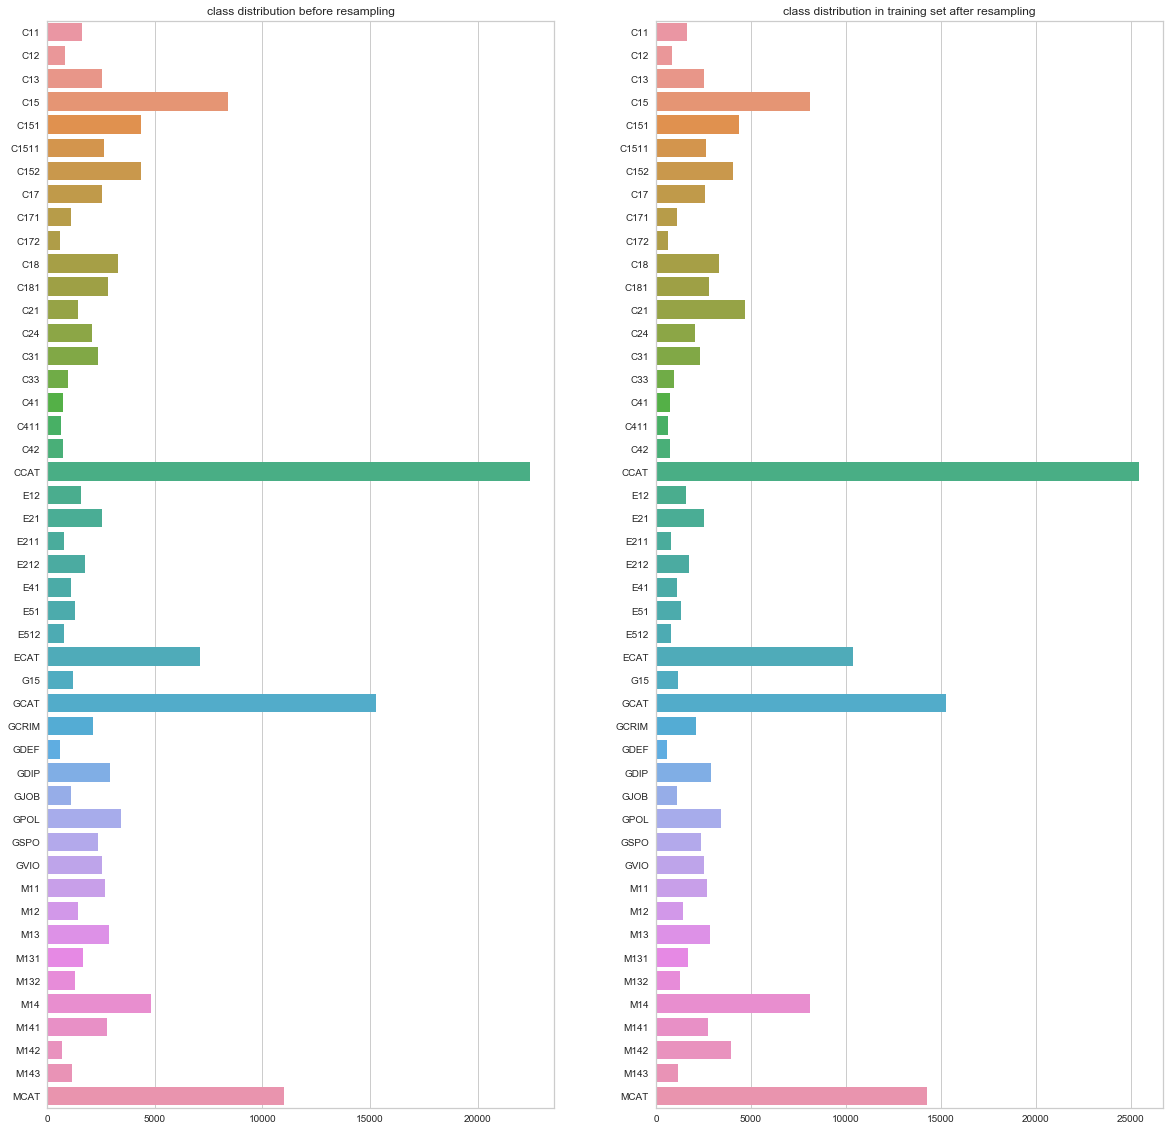

In [0]:
ClassDistributionPlot(label_df_Y, df_Y_label_resampled)

#Step 2: Perform Clustering

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


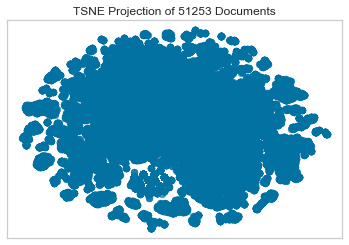

In [0]:
TsneVisualization(X_tfidf_resampled)

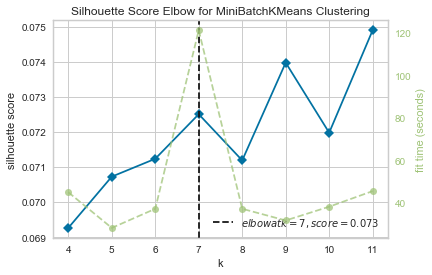

CLUSTER_COUNT: 7


In [0]:
CLUSTER_COUNT = ClusterCalcultor(X_tfidf_oversampled, visual=True)
print(f"CLUSTER_COUNT: {CLUSTER_COUNT}")

In [0]:
#clustering = KMeans(n_clusters=CLUSTER_COUNT, random_state=42, precompute_distances=True).fit(X_tfidf_resampled)
clustering = MiniBatchKMeans(n_clusters=CLUSTER_COUNT, random_state=42, init_size=1000, batch_size=1000).fit(X_tfidf_resampled)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

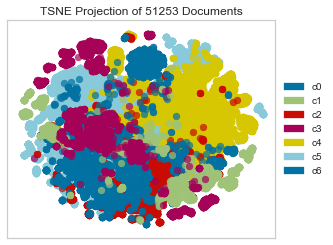

In [0]:
ClusterTsneVisualization(X_tfidf_resampled, clustering)

In [0]:
#retrieve assigned cluser ID's
clusterId = np.array(clustering.labels_)

#Append cluster IDs to label dataframe
df_Y = df_Y_label_resampled.copy()
df_Y["clusterId"] = clusterId
print(df_Y)

#Append cluster IDs to feature dataframe
df_X = df_X_tfidf_resampled.copy()
df_X["clusterId"] = clusterId
print(df_X)

#Print to file - Checkpoint
#df_Y.to_csv("project_labels_df.csv")
#df_X.to_csv("project_features_df.csv")

       C11  C12  C13  C15  C151  C1511  C152  C17  C171  C172  ...  M12  M13  \
0        0    0    0    0     0      0     0    0     0     0  ...    0    0   
1        0    0    0    0     0      0     0    0     0     0  ...    0    0   
2        0    0    0    0     0      0     0    0     0     0  ...    0    0   
3        0    0    0    0     0      0     0    0     0     0  ...    0    0   
4        0    0    0    0     0      0     0    0     0     0  ...    0    1   
...    ...  ...  ...  ...   ...    ...   ...  ...   ...   ...  ...  ...  ...   
51248    0    0    0    0     0      0     0    0     0     0  ...    0    0   
51249    0    0    0    0     0      0     0    0     0     0  ...    0    0   
51250    0    0    0    0     0      0     0    0     0     0  ...    0    0   
51251    0    0    0    0     0      0     0    0     0     0  ...    0    0   
51252    0    0    0    0     0      0     0    0     0     0  ...    0    0   

       M131  M132  M14  M141  M142  M14

# Explanation for Preprocessing and clustering documents:
In this step, the data is read from the CSV file and stored in a dataframe for preprocessing. As an initial step, all the text data is converted to lowercase and tokenized. Any special characters, empty fields and stop words are removed (nltk stopwords list used) from the text data. POS tagging is done on the tokenized text for performing effective lemmatization. The lemmatized list is then vectorized and the TF-IDF values are generated for the top 7000 features. The labels for the extracted features are vectorized using MultiLabelBinarizer from sklearn. This is done to train a multi-label classifier for the extracted text data. At this stage, the data seemed to imbalanced with high number of representation for few labels. Sampling techniques were used to balance the dataset for performing effective classification. The minority classes were oversampled using RandomOverSampler and the majority classes were undersampled using TomekLinks to balance the dataset. Labels which had less than 1% representation in the feature set were dropped since, there were not enough samples to oversample these classes.
 

To efficiently classify the text data, the documents are clustered using MiniBatchKMeans. The MiniBatchKMeans is a different implementation of the KMeans clustering algorithm that uses mini-batches to reduce the computation time, while optimising the same objective function. KElbowVisualizer from the yellow-brick library is used to identify the optimum number of clusters for the MiniBatchKMeans algorithm. Based on the results from the elbow method, seven clusters were formed for the documents. Documents in each cluster with their respective labels were then used to train the MLP classification model. LabelPowerset from skmultilearn is being used to transform the ylabels into a label encoded format which is acceptable by the MLP classifier.


#Step 3 : Evaluate Cluster Quality

In [0]:
evaluate_cluster_quality(X_tfidf_resampled, clustering)

silhouette_score: 0.07104094718826559
calinski_harabasz_score: 822.9693311516469
davies_bouldin_score: 7.826961968310812


# Evaluate Clusters Quality
Three different metrics have been used to identify the cluster quality.

1. **silhouette_score:** This metric calculates the Silhouette Coefficient for 
the cluster by finding the ratio between the difference of mean intra-cluster distance and the nearest-cluster distance to that of the maximum distance between the clusters. Presence of overlapping clusters are expected because of the multi-label classification problem in hand. This theory is confirmed by a near zero positive Silhouette score obtained from the clusters formed. 

2. **Calinski_harabasz_score:** This metric which is also referred to as the Variance Ratio Criterion is used when the ground truth labels are not known and results are to be obtained on a huge volume of data (due to quick processing time). The value for this metric is calculated by the ratio between the intra-cluster and inter-cluster dispersion. A higher value of this metric represents clusters which are dense and seperate. For the problem in hand, getting a high Calinski_harabasz_score represents well defined clusters.

3. **davies_bouldin_score:**  A lower Davies-Bouldin index specifies a model which has better separation between the different clusters formed. This metric calculates the average similarity of each cluster with its most similar cluster. This is done by calculating the distance between clusters to that of the size of the clusters. For the problem in hand, receiving a lower Davies-Bouldin index indicates that the clusters formed are not similar to each other and the partitions are well formed. However, this metric can only be used in euclidean space due to usage of centroid distance. For text classification, using cosine similarity would have been a better approach. 

